The goal here is to evaluate the errors introduced adversarial training by a analyzing the added noise

In [113]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [114]:
origWeights = np.load('origWeights.npy')
modifiedWeights = np.load('modifiedWeights.npy')
origBiases = np.load('origBiases.npy')
modifiedBiases = np.load('modifiedBiases.npy')

In [115]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [116]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [117]:
# mnist images are grayscale, so the depth is 1. In cifar10, depth is 3.
# The first 5 layers are convolutional layers in case of cifar10 while 
# only the first 3 are in case of mnist.
if origWeights[0].shape[2] == 1:
    numConvLayers = 3
else:
    numConvLayers = 5
r = measure_noise(origWeights[:numConvLayers], modifiedWeights[:numConvLayers])
min_noise, max_noise = compute_minAndMax(r)
print(min_noise, max_noise)

-0.0055678636 0.005985737


In [118]:
for layer in r:
    print(layer.T.shape)
allMatrices = []
colors = []
if numConvLayers == 3:
    color = ['r', 'g', 'b']
else:
    color = ['r', 'g', 'b', 'y', 'c']

for layer,c in zip(r,color):
    for filter in layer.T:
        for matrix in filter:
            allMatrices.append(matrix.flatten())
            colors.append(c)
allMatrices_tsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(allMatrices)
print(allMatrices_tsne.shape)

(32, 3, 3, 3)
(32, 32, 3, 3)
(64, 32, 3, 3)
(64, 64, 3, 3)
(128, 64, 3, 3)
(15456, 2)


Text(0.5, 1.0, 'Model Noise')

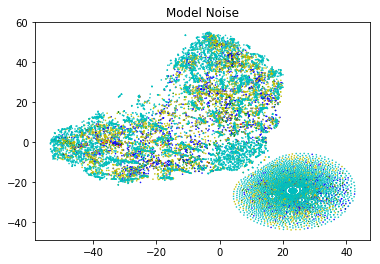

In [119]:
allMatrices_x, allMatrices_y = allMatrices_tsne.T
#plt.figure(figsize=(20,20))
plt.scatter(allMatrices_x, allMatrices_y, s=0.3, c=colors)
plt.title('Model Noise')

Text(0.5, 1.0, 'Model Noise')

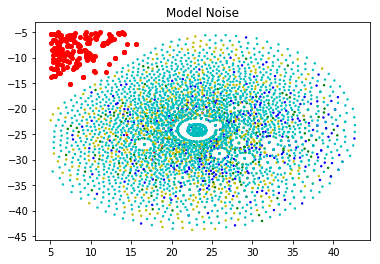

In [138]:
# Code to isolate the circular pattern from the plot
# Using 4 threshold values, I isolate the rectangular 
# region of the plot which contains the circular pattern
x_range = (5,50)
y_range = (-50,-5)
indices = (allMatrices_x < x_range[1]) * (allMatrices_y < y_range[1]) * \
(allMatrices_x > x_range[0]) * (allMatrices_y > y_range[0])

# Plot the isolated pattern to verify that circular pattern 
# was correctly isolated
colors = np.array(colors)
plt.scatter(allMatrices_x[indices], allMatrices_y[indices], c = colors[indices], s=2)
for idx in nonZeroPatternIndices:
    plt.plot(allMatrices_x[idx], allMatrices_y[idx], 'ro', markersize=4)
plt.title('Model Noise')

In [135]:
len(np.nonzero(indices)[0])

4250

In [136]:
patternIndices = np.nonzero(indices)[0]
print(patternIndices)

[   15    16    17 ... 15446 15452 15453]


In [137]:
nonZeroPatternIndices =[]
for idx in np.nditer(patternIndices):
    if (allMatrices[idx] != 0).any():
        nonZeroPatternIndices.append(idx)
        print(idx)

278
324
398
470
534
598
726
758
870
1078
1336
1920
2743
2791
2840
3740
3889
3924
4143
4300
4307
5048
5136
5137
5666
6126
6132
6147
6388
6417
6521
6547
6636
6773
6865
7010
7310
7339
7403
7406
7453
7466
7479
7598
7644
7645
7659
7670
7735
7758
7780
7782
7784
7806
7855
7893
8024
8107
8156
8164
8165
8166
8214
8254
8311
8346
8398
8407
8532
8537
8538
8796
8860
8910
9134
9157
9175
9179
9180
9309
9418
9526
9533
9597
9629
9783
9830
9832
9870
9981
10110
10140
10200
10272
10277
10280
10292
10299
10311
10315
10404
10415
10422
10434
10450
10451
10455
10798
10816
10844
10862
10981
11006
11033
11086
11173
11174
11181
11202
11229
11406
11420
11480
11499
11639
11790
11830
11838
11860
11868
11869
11877
11880
11882
11918
12003
12004
12030
12032
12042
12045
12049
12056
12061
12062
12200
12206
12222
12224
12238
12279
12302
12366
12430
12458
12487
12491
12494
12503
12504
12542
12572
12662
12670
12692
12764
12786
12826
12839
12871
12874
12878
13213
13302
13326
13335
13355
13374
13378
13381
13400
13405
13494
1

In [139]:
allMatrices[7598]

array([ 2.5928020e-06, -1.6391277e-06, -1.0281801e-06,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -1.4454126e-06,  1.6950071e-06,
        1.9639265e-06], dtype=float32)

In [125]:
allRandom = []
for i in range(6176):
    randomFilter = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    allRandom.append(randomFilter.flatten())
#allRandom_tsne = TSNE(n_components=2, perplexity=40, n_iter=1200).fit_transform(allRandom)

In [126]:
allRandom_x, allRandom_y = allRandom_tsne.T
plt.scatter(allRandom_x, allRandom_y, s=0.3)
plt.title('Random Noise')

NameError: name 'allRandom_tsne' is not defined

In [ ]:
H = np.transpose(r[2])
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    axarr[num//5][num%5].imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()

In [ ]:
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    H = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    axarr.ravel()[num].imshow(H, cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()